# Diabetes Onset Detection -- Modeling 2

## Goal
1. Try different algorithms and build the prediction model, using f1 score as our error metrics
    * Naive Bayes
    * K-Nearest Neighbors
    * Logistic Regression
    * Decision Tree
    * Random Forest
    * Support Vector Machine
    * Gradient Boosting
2. Compare the performance of different imputation and normalization methods
    * impute with mean
    * impute with median
    * z-score normalization
    * min-max scaling

In [129]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# supress warnings
import warnings
warnings.filterwarnings("ignore")

sns.set()
sns.set_style("whitegrid")

# import model package
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

# import customized package
from MLuseful import get_best_model_accuracy
from MLuseful import roc_curve_plot
from MLuseful import print_confusion_matrix

### Loading data
We will load the training and testing set from the feature engineering step and we will be ready to fit the model

In [130]:
diabetes = pd.read_csv('../Data/diabetes_outliers_clean.csv')

# z-score normalization
diabetes_mean_X_train_z = pd.read_csv('../Data/diabetes_mean_X_train_z.csv')
diabetes_mean_X_test_z = pd.read_csv('../Data/diabetes_mean_X_test_z.csv')
diabetes_median_X_train_z = pd.read_csv('../Data/diabetes_median_X_train_z.csv')
diabetes_median_X_test_z = pd.read_csv('../Data/diabetes_median_X_test_z.csv')
diabetes_mean_X_train_z_PCA = pd.read_csv('../Data/diabetes_mean_X_train_z_PCA.csv')
diabetes_median_X_train_z_PCA = pd.read_csv('../Data/diabetes_median_X_train_z_PCA.csv')
diabetes_mean_X_test_z_PCA = pd.read_csv('../Data/diabetes_mean_X_test_z_PCA.csv')
diabetes_median_X_test_z_PCA = pd.read_csv('../Data/diabetes_median_X_test_z_PCA.csv')

# min-max scaling
diabetes_mean_X_train_min_max = pd.read_csv('../Data/diabetes_mean_X_train_min_max.csv')
diabetes_mean_X_test_min_max = pd.read_csv('../Data/diabetes_mean_X_test_min_max.csv')
diabetes_median_X_train_min_max = pd.read_csv('../Data/diabetes_median_X_train_min_max.csv')
diabetes_median_X_test_min_max = pd.read_csv('../Data/diabetes_median_X_test_min_max.csv')
diabetes_mean_X_train_min_max_PCA = pd.read_csv('../Data/diabetes_mean_X_train_min_max_PCA.csv')
diabetes_median_X_train_min_max_PCA = pd.read_csv('../Data/diabetes_median_X_train_min_max_PCA.csv')
diabetes_mean_X_test_min_max_PCA = pd.read_csv('../Data/diabetes_mean_X_test_min_max_PCA.csv')
diabetes_median_X_test_min_max_PCA = pd.read_csv('../Data/diabetes_median_X_test_min_max_PCA.csv')

diabetes_y_train = pd.read_csv('../Data/diabetes_y_train.csv', header=None)
diabetes_y_test = pd.read_csv('../Data/diabetes_y_test.csv', header=None)

### Precision v.s. Recall

In medical diagnostics, there are different aspects to consider whether the accuracy score is a suitable matrix to define a good predictive model or not, this is especially true in a rare disease case that only small portion of people has a certain disease, for example, 0.01%, if we predict 0(no disease) for all patients, we could get a 0.9999 accuracy score since most of them are zero, but this isn't too useful. The dataset we have was not that imbalance, the percentage of diabetic patient is around 34.9%, this makes using the accuracy score to determine the best algorithm acceptable. However, if we further consider the cost of misdiagnose a patient, we need to take precision and recall into accout. Precision is the ratio between true positives and number of predicted positive, that is, out of the patients we have predicted are diabetic, what is the percentage of patients that really have diabetes? Recall on the other hand, is the ratio between true positives and number of actual positives, that is, out of the all the diabetic patients, what are the percentage that we actually predicted them have diabetes?

Whether which one is more important depends on the cost of falsely identify a patient that has diabetes when they actually not and the cost of falsely identify a patient that does not have diabetes when they actually has it. In medical diagnostic, the cost of the second case is usually much more higher than the first, thus we might want to avoid the second case as much as we can, in other words, we want our recall to be higher, in order to diagnose as many patients as we can out of all the diabetic patients.

In this notebook, we will use the f1 score instead of accuracy to identify the best algorithm we have, the f1 score basically composed of two other measurement, precision and recall, the formula is f1=2$\frac{PR}{(P+R)}$, this can prevent either precision or recall is a lot higher than the other, the perfect score of f1 is 1 

In [131]:
# data dictionary
data_all_train = {'mean-z-score': diabetes_mean_X_train_z, 'median-z-score': diabetes_median_X_train_z,
'mean-min-max': diabetes_mean_X_train_min_max, 'median-min-max': diabetes_median_X_train_min_max,
'mean-z-score-PCA': diabetes_mean_X_train_z_PCA, 'median-z-score-PCA': diabetes_median_X_train_z_PCA,
'mean-min-max-PCA': diabetes_mean_X_train_min_max_PCA, 'median-min-max-PCA': diabetes_median_X_train_min_max_PCA}

data_all_test = {'mean-z-score': diabetes_mean_X_test_z, 'median-z-score': diabetes_median_X_test_z,
'mean-min-max': diabetes_mean_X_test_min_max, 'median-min-max': diabetes_median_X_test_min_max,
'mean-z-score-PCA': diabetes_mean_X_test_z_PCA, 'median-z-score-PCA': diabetes_median_X_test_z_PCA,
'mean-min-max-PCA': diabetes_mean_X_test_min_max_PCA, 'median-min-max-PCA': diabetes_median_X_test_min_max_PCA}

In [132]:
# algorithm dictionary
algorithm = {'Naive_Bayes': GaussianNB, 'KNN': KNeighborsClassifier, 'Logistic_regression': LogisticRegression, 
        'Decision_tree': DecisionTreeClassifier, 'Random_forest': RandomForestClassifier, 
        'LSVM': LinearSVC, 'SVM': SVC, 'Gradient_boosting': GradientBoostingClassifier}

In [133]:
# parameters dictionary
params = {'Naive_Bayes': {'var_smoothing': [1e-11, 1e-10, 1e-9, 1e-8, 1e-7]},
              'KNN': {'n_neighbors': [1,3,5,7,9,11]}, 
              'Logistic_regression': {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10]}, 
              'Decision_tree': {'criterion': ['gini', 'entropy'], 'max_depth': [1,3,5,7,9,11],}, 
              'Random_forest': {'n_estimators': [10, 50, 100, 500], 'max_depth': [1,3,5,7,9]},
              'LSVM': {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}, 
              'SVM': {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf', 'poly']}, 
              'Gradient_boosting': {'learning_rate': [0.01, 0.05, 0.1, 0.5, 1], 'n_estimators': [50, 100, 500]}}

In [134]:
# create a new dictionary to collect all the score and all the best parameters
all_score = {}
all_params = {}

In [135]:
# create helper function
def f1score(algo):
    temp_score = []
    temp_param = []
    print(algo)
    print('\n')
    for name, data in data_all_train.items():
        print(name)
        print('-'*90)
        best, score = get_best_model_accuracy(model=algorithm[algo](),
                                              params=params[algo], 
                                              X=data, 
                                              y=diabetes_y_train,
                                              score='f1')
        print('\n')
        temp_score.append(score)
        temp_param.append(best)
    all_score[algo] = temp_score
    all_params[algo] = temp_param

#### Naive Bayes

In [136]:
f1score('Naive_Bayes')

Naive_Bayes


mean-z-score
------------------------------------------------------------------------------------------
Best f1 : 0.6354101671886934
Best Parameters: {'var_smoothing': 1e-11}
Average Time to Fit (s): 0.003
Average Time to Score (s): 0.002


median-z-score
------------------------------------------------------------------------------------------
Best f1 : 0.6279184228351525
Best Parameters: {'var_smoothing': 1e-11}
Average Time to Fit (s): 0.003
Average Time to Score (s): 0.002


mean-min-max
------------------------------------------------------------------------------------------
Best f1 : 0.6354101671886934
Best Parameters: {'var_smoothing': 1e-11}
Average Time to Fit (s): 0.002
Average Time to Score (s): 0.001


median-min-max
------------------------------------------------------------------------------------------
Best f1 : 0.6279184228351525
Best Parameters: {'var_smoothing': 1e-11}
Average Time to Fit (s): 0.003
Average Time to Score (s): 0.002


mean-z-score-PCA
-

#### K-nearest neighbor

In [137]:
f1score('KNN')

KNN


mean-z-score
------------------------------------------------------------------------------------------
Best f1 : 0.651952699206329
Best Parameters: {'n_neighbors': 9}
Average Time to Fit (s): 0.003
Average Time to Score (s): 0.004


median-z-score
------------------------------------------------------------------------------------------
Best f1 : 0.6479729012361284
Best Parameters: {'n_neighbors': 11}
Average Time to Fit (s): 0.003
Average Time to Score (s): 0.003


mean-min-max
------------------------------------------------------------------------------------------
Best f1 : 0.657309509241446
Best Parameters: {'n_neighbors': 11}
Average Time to Fit (s): 0.003
Average Time to Score (s): 0.003


median-min-max
------------------------------------------------------------------------------------------
Best f1 : 0.659734525876837
Best Parameters: {'n_neighbors': 9}
Average Time to Fit (s): 0.004
Average Time to Score (s): 0.005


mean-z-score-PCA
----------------------------------

#### Logistic Regression

In [138]:
f1score('Logistic_regression')

Logistic_regression


mean-z-score
------------------------------------------------------------------------------------------
Best f1 : 0.6379921822618175
Best Parameters: {'C': 0.1, 'penalty': 'l1'}
Average Time to Fit (s): 0.004
Average Time to Score (s): 0.002


median-z-score
------------------------------------------------------------------------------------------
Best f1 : 0.6379921822618175
Best Parameters: {'C': 0.1, 'penalty': 'l1'}
Average Time to Fit (s): 0.004
Average Time to Score (s): 0.001


mean-min-max
------------------------------------------------------------------------------------------
Best f1 : 0.6219111551686661
Best Parameters: {'C': 10, 'penalty': 'l1'}
Average Time to Fit (s): 0.006
Average Time to Score (s): 0.001


median-min-max
------------------------------------------------------------------------------------------
Best f1 : 0.6283289045036546
Best Parameters: {'C': 10, 'penalty': 'l1'}
Average Time to Fit (s): 0.011
Average Time to Score (s): 0.002




#### Decision tree

In [139]:
f1score('Decision_tree')

Decision_tree


mean-z-score
------------------------------------------------------------------------------------------
Best f1 : 0.6208241925051186
Best Parameters: {'criterion': 'gini', 'max_depth': 5}
Average Time to Fit (s): 0.005
Average Time to Score (s): 0.002


median-z-score
------------------------------------------------------------------------------------------
Best f1 : 0.6239546890861783
Best Parameters: {'criterion': 'entropy', 'max_depth': 3}
Average Time to Fit (s): 0.005
Average Time to Score (s): 0.002


mean-min-max
------------------------------------------------------------------------------------------
Best f1 : 0.614012037145477
Best Parameters: {'criterion': 'gini', 'max_depth': 5}
Average Time to Fit (s): 0.005
Average Time to Score (s): 0.002


median-min-max
------------------------------------------------------------------------------------------
Best f1 : 0.6239546890861783
Best Parameters: {'criterion': 'entropy', 'max_depth': 3}
Average Time to Fit (s): 

#### Random forest

In [140]:
f1score('Random_forest')

Random_forest


mean-z-score
------------------------------------------------------------------------------------------
Best f1 : 0.6485368828037549
Best Parameters: {'max_depth': 7, 'n_estimators': 10}
Average Time to Fit (s): 0.174
Average Time to Score (s): 0.017


median-z-score
------------------------------------------------------------------------------------------
Best f1 : 0.659906911234635
Best Parameters: {'max_depth': 9, 'n_estimators': 10}
Average Time to Fit (s): 0.174
Average Time to Score (s): 0.017


mean-min-max
------------------------------------------------------------------------------------------
Best f1 : 0.6546873259163761
Best Parameters: {'max_depth': 9, 'n_estimators': 100}
Average Time to Fit (s): 0.173
Average Time to Score (s): 0.017


median-min-max
------------------------------------------------------------------------------------------
Best f1 : 0.6549838043119786
Best Parameters: {'max_depth': 9, 'n_estimators': 10}
Average Time to Fit (s): 0.172
Ave

#### Support vector machine

In [141]:
f1score('LSVM')

LSVM


mean-z-score
------------------------------------------------------------------------------------------
Best f1 : 0.6195549888478795
Best Parameters: {'C': 0.01, 'penalty': 'l2'}
Average Time to Fit (s): 0.009
Average Time to Score (s): 0.001


median-z-score
------------------------------------------------------------------------------------------
Best f1 : 0.6266162339617574
Best Parameters: {'C': 10, 'penalty': 'l2'}
Average Time to Fit (s): 0.009
Average Time to Score (s): 0.001


mean-min-max
------------------------------------------------------------------------------------------
Best f1 : 0.620689190662357
Best Parameters: {'C': 0.1, 'penalty': 'l2'}
Average Time to Fit (s): 0.007
Average Time to Score (s): 0.001


median-min-max
------------------------------------------------------------------------------------------
Best f1 : 0.625281579760594
Best Parameters: {'C': 1, 'penalty': 'l2'}
Average Time to Fit (s): 0.007
Average Time to Score (s): 0.001


mean-z-score-PCA


In [142]:
f1score('SVM')

SVM


mean-z-score
------------------------------------------------------------------------------------------
Best f1 : 0.6273512315976606
Best Parameters: {'C': 10, 'kernel': 'rbf'}
Average Time to Fit (s): 0.016
Average Time to Score (s): 0.002


median-z-score
------------------------------------------------------------------------------------------
Best f1 : 0.6166137688995508
Best Parameters: {'C': 10, 'kernel': 'rbf'}
Average Time to Fit (s): 0.015
Average Time to Score (s): 0.002


mean-min-max
------------------------------------------------------------------------------------------
Best f1 : 0.6235213030480099
Best Parameters: {'C': 100, 'kernel': 'rbf'}
Average Time to Fit (s): 0.006
Average Time to Score (s): 0.002


median-min-max
------------------------------------------------------------------------------------------
Best f1 : 0.6253499128972189
Best Parameters: {'C': 100, 'kernel': 'rbf'}
Average Time to Fit (s): 0.006
Average Time to Score (s): 0.002


mean-z-score-PCA

#### Gradient boosting

In [143]:
f1score('Gradient_boosting')

Gradient_boosting


mean-z-score
------------------------------------------------------------------------------------------
Best f1 : 0.6278829872171983
Best Parameters: {'learning_rate': 0.05, 'n_estimators': 100}
Average Time to Fit (s): 0.191
Average Time to Score (s): 0.002


median-z-score
------------------------------------------------------------------------------------------
Best f1 : 0.6358815379598336
Best Parameters: {'learning_rate': 0.05, 'n_estimators': 100}
Average Time to Fit (s): 0.19
Average Time to Score (s): 0.002


mean-min-max
------------------------------------------------------------------------------------------
Best f1 : 0.6300667770961974
Best Parameters: {'learning_rate': 0.05, 'n_estimators': 100}
Average Time to Fit (s): 0.19
Average Time to Score (s): 0.002


median-min-max
------------------------------------------------------------------------------------------
Best f1 : 0.6311929836185955
Best Parameters: {'learning_rate': 0.1, 'n_estimators': 100}
A

### Confusion matrix and ROC curve
From above, we have ran all combinations of models and data, our next step is to use confusion matrix on our test set to see the true positive, true negative, false positive and false negative, we will run the test set to see the f1 score as well, finally, we will plot the ROC curve of each model and find out the area under the curve, the ROC curve is created by plotting the recall(true positive rate) against the false positive rate at various threshold setting, this basically visually reflects the f1 score 

We will select the best 2 scores in each model and use the customized function `roc_curve_plot` and `print_confusion_matrix` to help the plotting

In [144]:
# create a dataframe for the score
all_score_f1_df = pd.DataFrame(all_score, index=['mean-z-score', 'median-z-score', 'mean-min-max',
                                              'median-min-max', 'mean-z-score-PCA', 'median-z-score-PCA',
                                              'mean-min-max-PCA', 'median-min-max-PCA'])

# add an average column to show the mean score of the data from all algorithms
all_score_f1_df['Avg_sscore'] = all_score_f1_df.mean(axis=1)
all_score_f1_df

,Naive_Bayes,KNN,Logistic_regression,Decision_tree,Random_forest,LSVM,SVM,Gradient_boosting,Avg_sscore
mean-z-score,0.635410,0.651953,0.637992,0.620824,0.648537,0.619555,0.627351,0.627883,0.633688
median-z-score,0.627918,0.647973,0.637992,0.623955,0.659907,0.626616,0.616614,0.635882,0.634607
mean-min-max,0.635410,0.657310,0.621911,0.614012,0.654687,0.620689,0.623521,0.630067,0.632201
median-min-max,0.627918,0.659735,0.628329,0.623955,0.654984,0.625282,0.625350,0.631193,0.634593
mean-z-score-PCA,0.543295,0.591735,0.613367,0.594778,0.605111,0.527566,0.599012,0.610878,0.585718
median-z-score-PCA,0.533039,0.587285,0.607730,0.595901,0.615843,0.528292,0.571686,0.595544,0.579415
mean-min-max-PCA,0.549317,0.588130,0.561808,0.641460,0.605850,0.562251,0.550529,0.599929,0.582409
median-min-max-PCA,0.555010,0.562754,0.563249,0.656909,0.611704,0.562466,0.549800,0.610107,0.584000


In [145]:
# take the average by algorithm
all_score_f1_df.mean()

Naive_Bayes            0.588415
KNN                    0.618359
Logistic_regression    0.609047
Decision_tree          0.621474
Random_forest          0.632078
LSVM                   0.584090
SVM                    0.595483
Gradient_boosting      0.617685
Avg_sscore             0.608329
dtype: float64

In [146]:
# create a dataframe for all the parameters
all_params_f1_df = pd.DataFrame(all_params, index=['mean-z-score', 'median-z-score', 'mean-min-max',
                                              'median-min-max', 'mean-z-score-PCA', 'median-z-score-PCA',
                                              'mean-min-max-PCA', 'median-min-max-PCA'])
all_params_f1_df

,Naive_Bayes,KNN,Logistic_regression,Decision_tree,Random_forest,LSVM,SVM,Gradient_boosting
mean-z-score,{'var_smoothing': 1e-11},{'n_neighbors': 9},"{'C': 0.1, 'penalty': 'l1'}","{'criterion': 'gini', 'max_depth': 5}","{'max_depth': 7, 'n_estimators': 10}","{'C': 0.01, 'penalty': 'l2'}","{'C': 10, 'kernel': 'rbf'}","{'learning_rate': 0.05, 'n_estimators': 100}"
median-z-score,{'var_smoothing': 1e-11},{'n_neighbors': 11},"{'C': 0.1, 'penalty': 'l1'}","{'criterion': 'entropy', 'max_depth': 3}","{'max_depth': 9, 'n_estimators': 10}","{'C': 10, 'penalty': 'l2'}","{'C': 10, 'kernel': 'rbf'}","{'learning_rate': 0.05, 'n_estimators': 100}"
mean-min-max,{'var_smoothing': 1e-11},{'n_neighbors': 11},"{'C': 10, 'penalty': 'l1'}","{'criterion': 'gini', 'max_depth': 5}","{'max_depth': 9, 'n_estimators': 100}","{'C': 0.1, 'penalty': 'l2'}","{'C': 100, 'kernel': 'rbf'}","{'learning_rate': 0.05, 'n_estimators': 100}"
median-min-max,{'var_smoothing': 1e-11},{'n_neighbors': 9},"{'C': 10, 'penalty': 'l1'}","{'criterion': 'entropy', 'max_depth': 3}","{'max_depth': 9, 'n_estimators': 10}","{'C': 1, 'penalty': 'l2'}","{'C': 100, 'kernel': 'rbf'}","{'learning_rate': 0.1, 'n_estimators': 100}"
mean-z-score-PCA,{'var_smoothing': 1e-11},{'n_neighbors': 7},"{'C': 0.01, 'penalty': 'l1'}","{'criterion': 'gini', 'max_depth': 1}","{'max_depth': 9, 'n_estimators': 50}","{'C': 0.01, 'penalty': 'l2'}","{'C': 10, 'kernel': 'rbf'}","{'learning_rate': 0.1, 'n_estimators': 50}"
median-z-score-PCA,{'var_smoothing': 1e-11},{'n_neighbors': 9},"{'C': 0.01, 'penalty': 'l1'}","{'criterion': 'entropy', 'max_depth': 9}","{'max_depth': 5, 'n_estimators': 10}","{'C': 0.01, 'penalty': 'l2'}","{'C': 10, 'kernel': 'rbf'}","{'learning_rate': 0.05, 'n_estimators': 50}"
mean-min-max-PCA,{'var_smoothing': 1e-11},{'n_neighbors': 5},"{'C': 10, 'penalty': 'l2'}","{'criterion': 'gini', 'max_depth': 1}","{'max_depth': 5, 'n_estimators': 100}","{'C': 10, 'penalty': 'l2'}","{'C': 100, 'kernel': 'rbf'}","{'learning_rate': 0.1, 'n_estimators': 500}"
median-min-max-PCA,{'var_smoothing': 1e-11},{'n_neighbors': 3},"{'C': 10, 'penalty': 'l2'}","{'criterion': 'gini', 'max_depth': 3}","{'max_depth': 5, 'n_estimators': 500}","{'C': 100, 'penalty': 'l2'}","{'C': 100, 'kernel': 'rbf'}","{'learning_rate': 0.01, 'n_estimators': 500}"


In [147]:
# use pandas rank method on all_score_f1_df
rank = all_score_f1_df.rank(method='first', ascending=False)
rank

,Naive_Bayes,KNN,Logistic_regression,Decision_tree,Random_forest,LSVM,SVM,Gradient_boosting,Avg_sscore
mean-z-score,1.0,3.0,1.0,5.0,4.0,4.0,1.0,4.0,3.0
median-z-score,3.0,4.0,2.0,3.0,1.0,1.0,4.0,1.0,1.0
mean-min-max,2.0,2.0,4.0,6.0,3.0,3.0,3.0,3.0,4.0
median-min-max,4.0,1.0,3.0,4.0,2.0,2.0,2.0,2.0,2.0
mean-z-score-PCA,7.0,5.0,5.0,8.0,8.0,8.0,5.0,5.0,5.0
median-z-score-PCA,8.0,7.0,6.0,7.0,5.0,7.0,6.0,8.0,8.0
mean-min-max-PCA,6.0,6.0,8.0,2.0,7.0,6.0,7.0,7.0,7.0
median-min-max-PCA,5.0,8.0,7.0,1.0,6.0,5.0,8.0,6.0,6.0


In [148]:
# collect all the area under the curve and f1 score data
test_f1_auc = {}

In [149]:
# create a helper function to plot the confusion matrix on the test set and ROC curve on the training set 
def plot_roc_cm(algo):
    print(algo)
    print('\n')
    for data in rank[algo][rank[algo] < 3].index: # pick only the highest two
        model = algorithm[algo](**all_params_f1_df.loc[data, algo]) # fit the model with the best parameters
        model.fit(data_all_train[data], diabetes_y_train)
        print(data)
        print('-'*90)
        cm = confusion_matrix(diabetes_y_test, model.predict(data_all_test[data])) # creating confusion matrix
        
        print_confusion_matrix(cm, ['non_diabetic', 'diabetic'])
        pred = model.predict(data_all_test[data])
        # calculate f1 score
        f1 = f1_score(diabetes_y_test, pred)
        test_f1_auc[algo+'_'+data] = [round(f1,4)]
        
        # calculate recall
        recall = recall_score(diabetes_y_test, pred)
        test_f1_auc[algo+'_'+data].append(recall)
        
        # calculate precision
        precision = precision_score(diabetes_y_test, pred)
        test_f1_auc[algo+'_'+data].append(precision)
        
        # calculate accuracy
        accu = accuracy_score(diabetes_y_test, pred)
        test_f1_auc[algo+'_'+data].append(accu)
        
        # calculate AUC
        AUC = roc_curve_plot(algorithm[algo](), all_params_f1_df.loc[data, algo], X=data_all_test[data], 
                       y=diabetes_y_test)
        test_f1_auc[algo+'_'+data].append(AUC)
        print('f1 score on test set: {}'.format(f1))
        print('Precision on test set: {}'.format(precision))
        print('Recall on test set: {}'.format(recall))
        print('\n')
        

#### Naive Bayes

Naive_Bayes


mean-z-score
------------------------------------------------------------------------------------------


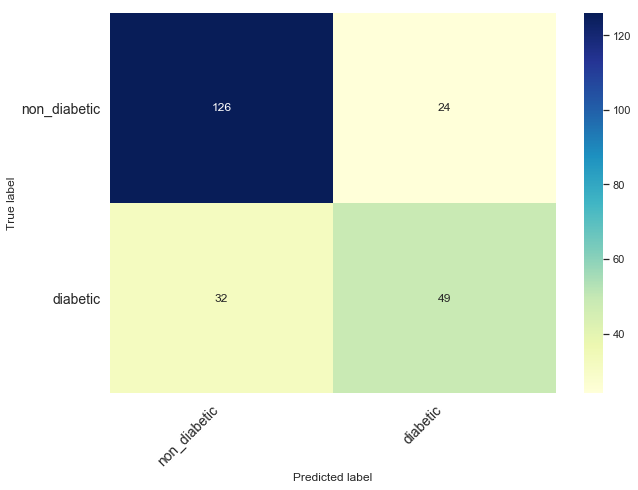

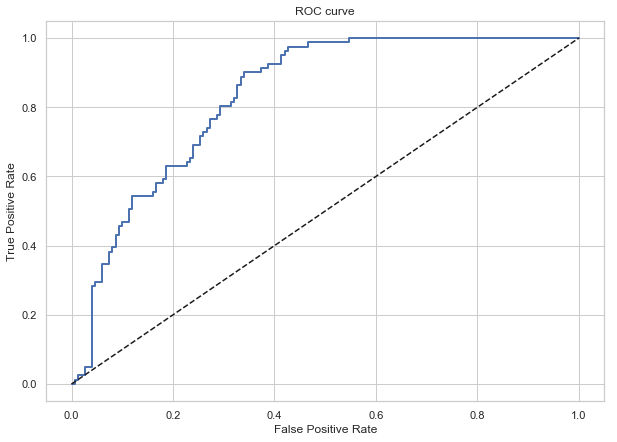

Area under the curve: 0.8320987654320987
f1 score on test set: 0.6363636363636364
Precision on test set: 0.6712328767123288
Recall on test set: 0.6049382716049383


mean-min-max
------------------------------------------------------------------------------------------


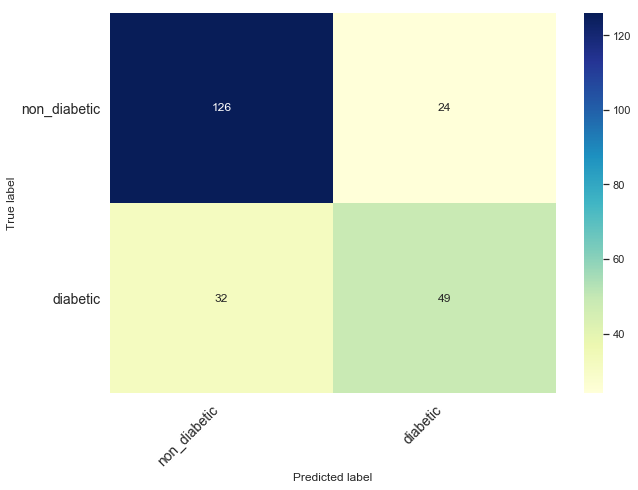

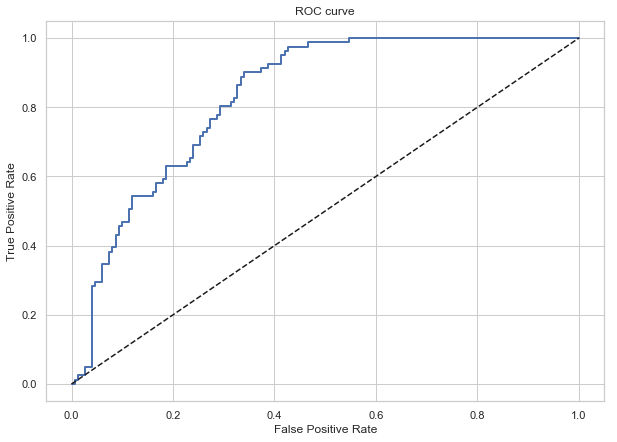

Area under the curve: 0.8320987654320987
f1 score on test set: 0.6363636363636364
Precision on test set: 0.6712328767123288
Recall on test set: 0.6049382716049383




In [150]:
plot_roc_cm('Naive_Bayes')

#### K-nearest neighbor

KNN


mean-min-max
------------------------------------------------------------------------------------------


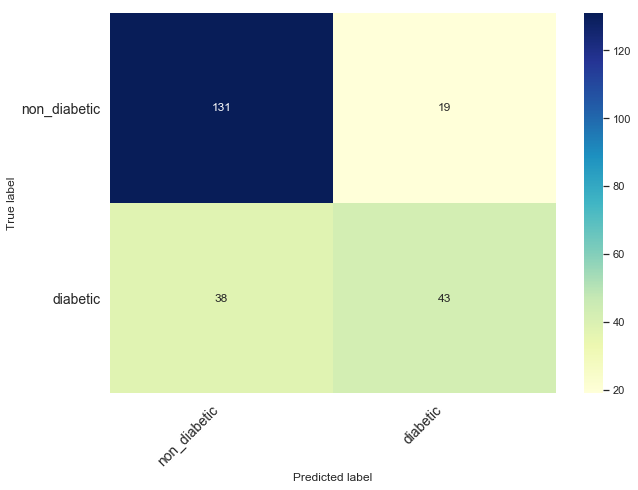

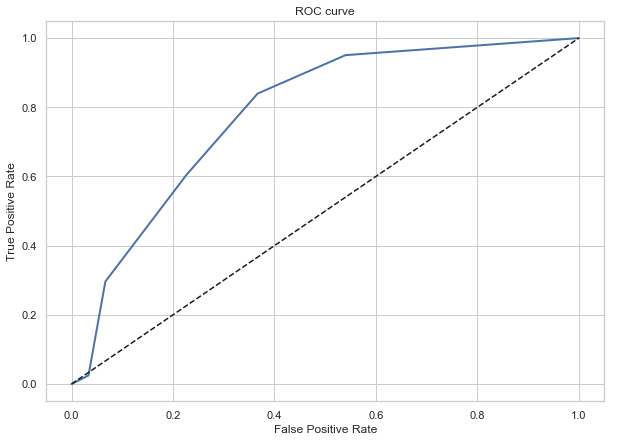

Area under the curve: 0.7827572016460905
f1 score on test set: 0.6013986013986015
Precision on test set: 0.6935483870967742
Recall on test set: 0.5308641975308642


median-min-max
------------------------------------------------------------------------------------------


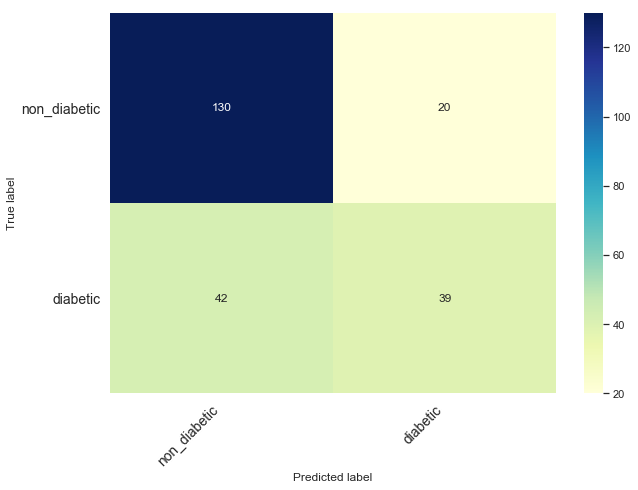

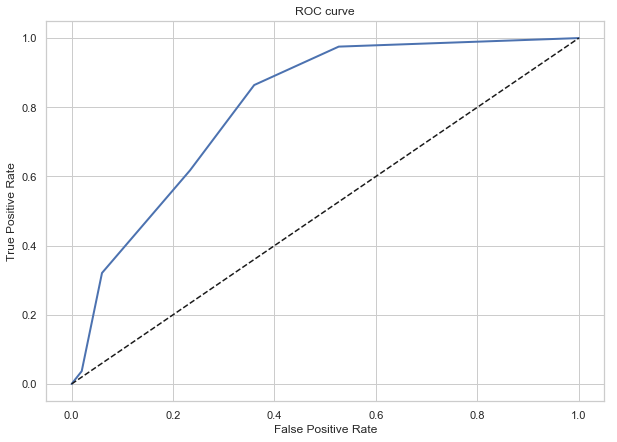

Area under the curve: 0.8034567901234568
f1 score on test set: 0.5571428571428572
Precision on test set: 0.6610169491525424
Recall on test set: 0.48148148148148145




In [151]:
plot_roc_cm('KNN')

#### Logistic Regression

Logistic_regression


mean-z-score
------------------------------------------------------------------------------------------


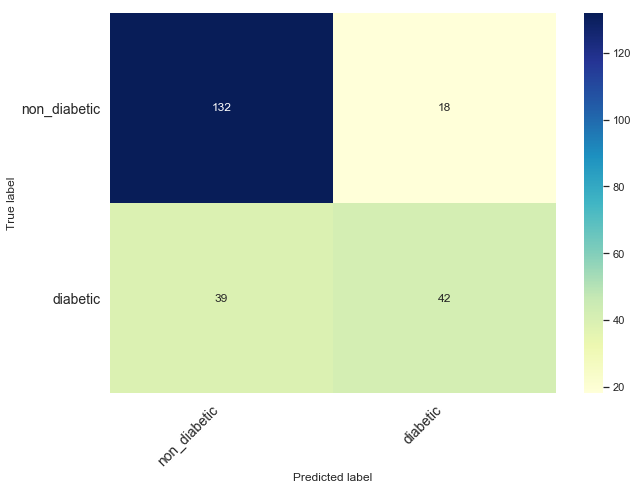

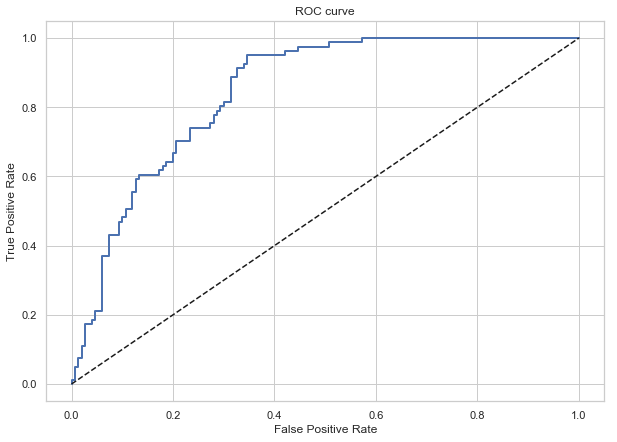

Area under the curve: 0.8445267489711934
f1 score on test set: 0.5957446808510639
Precision on test set: 0.7
Recall on test set: 0.5185185185185185


median-z-score
------------------------------------------------------------------------------------------


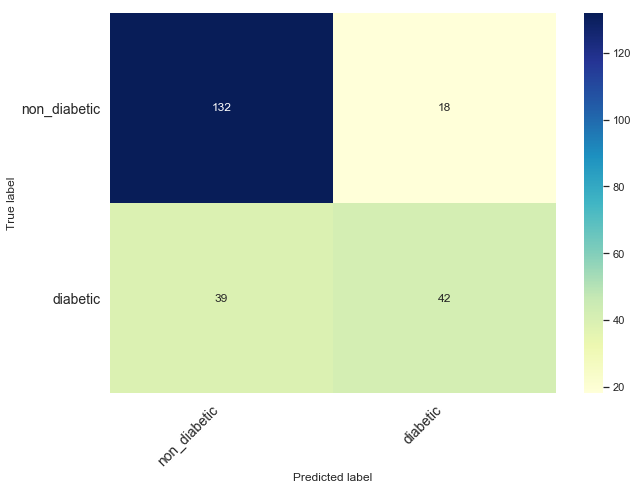

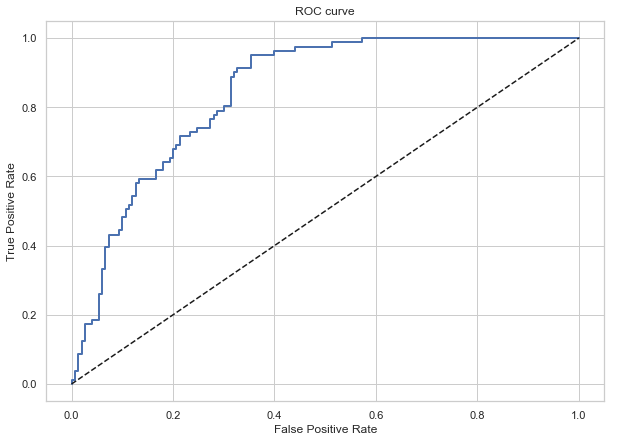

Area under the curve: 0.8441975308641976
f1 score on test set: 0.5957446808510639
Precision on test set: 0.7
Recall on test set: 0.5185185185185185




In [152]:
plot_roc_cm('Logistic_regression')

#### Decision tree

Decision_tree


mean-min-max-PCA
------------------------------------------------------------------------------------------


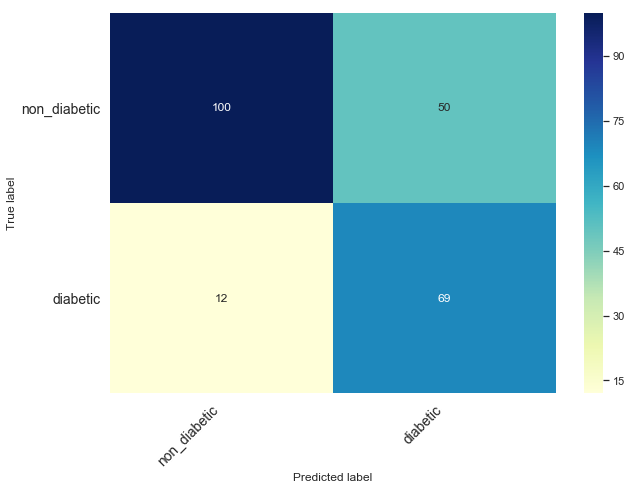

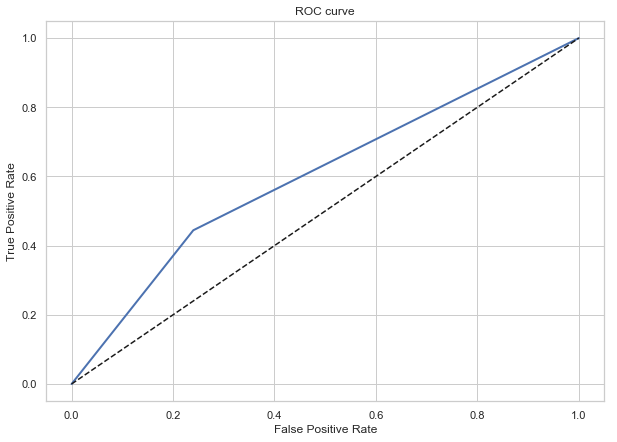

Area under the curve: 0.6022222222222222
f1 score on test set: 0.6900000000000001
Precision on test set: 0.5798319327731093
Recall on test set: 0.8518518518518519


median-min-max-PCA
------------------------------------------------------------------------------------------


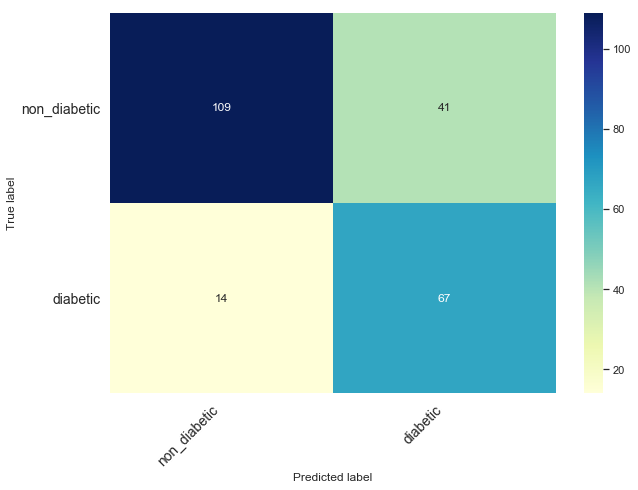

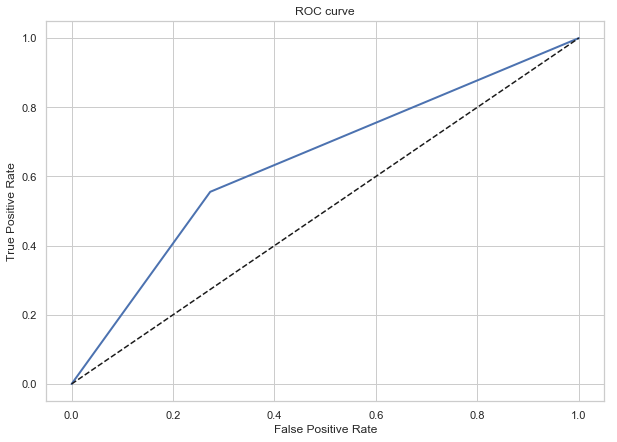

Area under the curve: 0.6411111111111112
f1 score on test set: 0.708994708994709
Precision on test set: 0.6203703703703703
Recall on test set: 0.8271604938271605




In [153]:
plot_roc_cm('Decision_tree')

#### Random forest

Random_forest


median-z-score
------------------------------------------------------------------------------------------


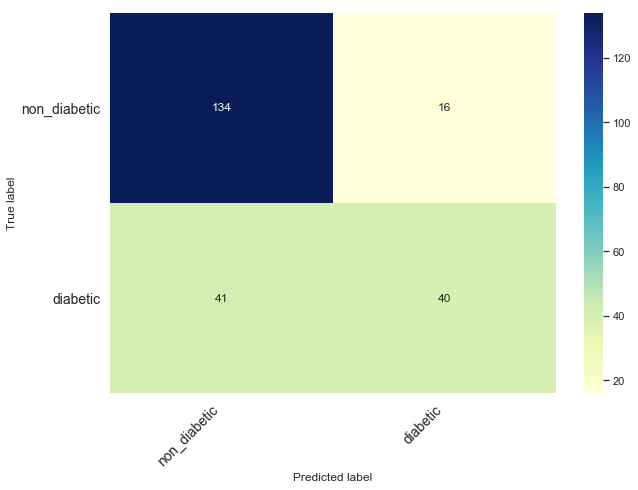

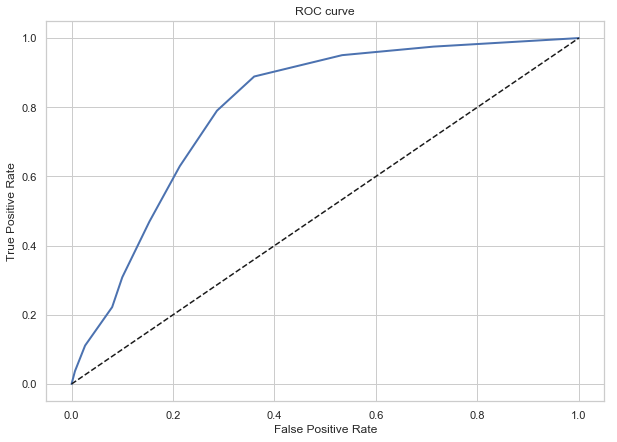

Area under the curve: 0.7990123456790124
f1 score on test set: 0.583941605839416
Precision on test set: 0.7142857142857143
Recall on test set: 0.49382716049382713


median-min-max
------------------------------------------------------------------------------------------


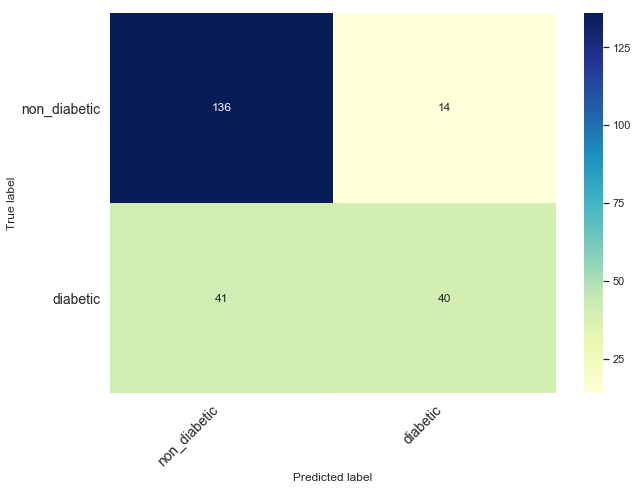

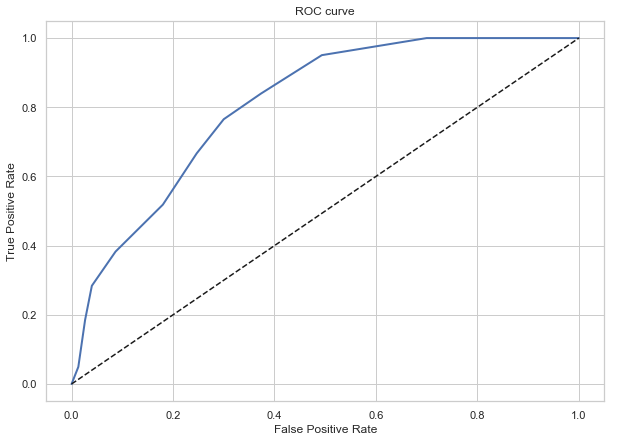

Area under the curve: 0.8081481481481482
f1 score on test set: 0.5925925925925926
Precision on test set: 0.7407407407407407
Recall on test set: 0.49382716049382713




In [154]:
plot_roc_cm('Random_forest')

#### Support vector machine

LSVM


median-z-score
------------------------------------------------------------------------------------------


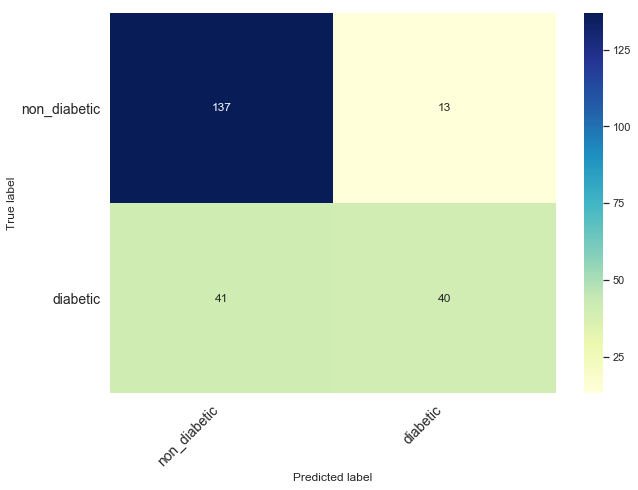

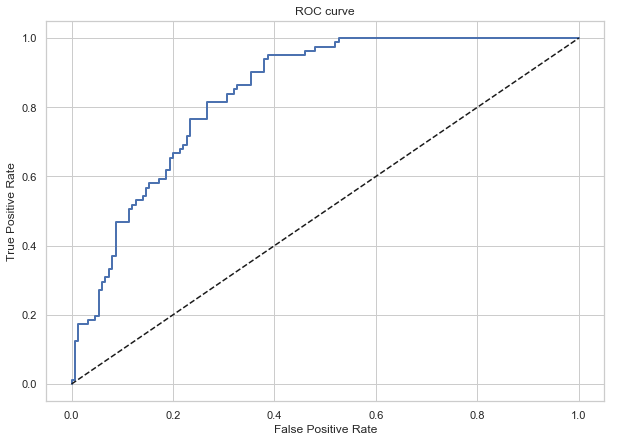

Area under the curve: 0.8395061728395061
f1 score on test set: 0.5970149253731344
Precision on test set: 0.7547169811320755
Recall on test set: 0.49382716049382713


median-min-max
------------------------------------------------------------------------------------------


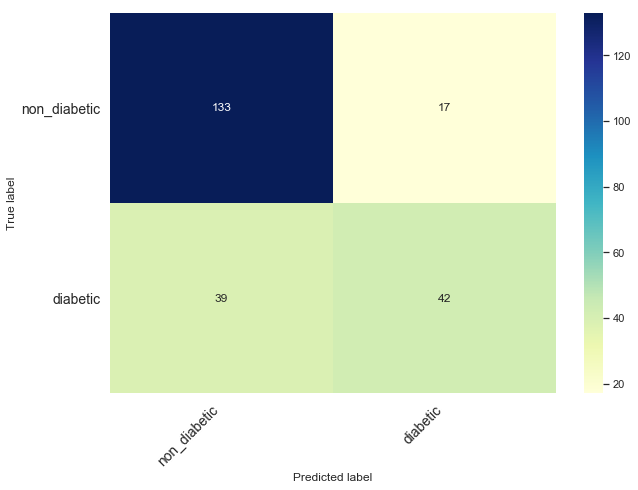

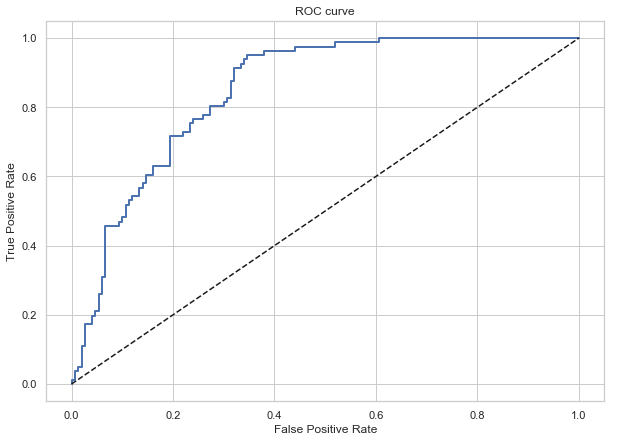

Area under the curve: 0.8483950617283951
f1 score on test set: 0.6
Precision on test set: 0.711864406779661
Recall on test set: 0.5185185185185185




In [155]:
plot_roc_cm('LSVM')

SVM


mean-z-score
------------------------------------------------------------------------------------------


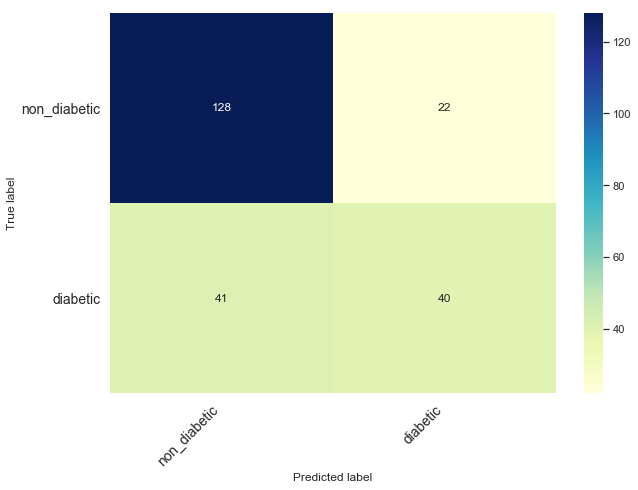

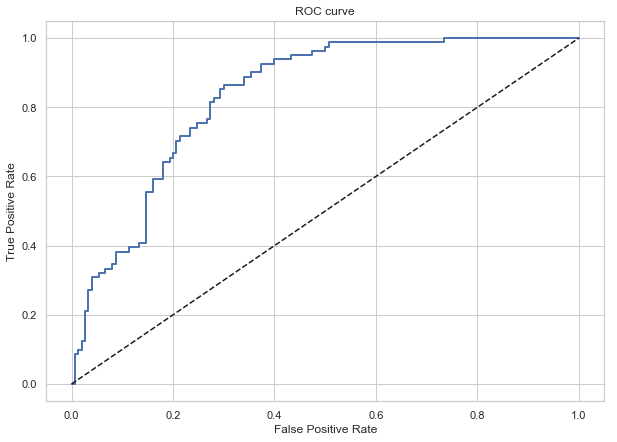

Area under the curve: 0.8329218106995885
f1 score on test set: 0.5594405594405595
Precision on test set: 0.6451612903225806
Recall on test set: 0.49382716049382713


median-min-max
------------------------------------------------------------------------------------------


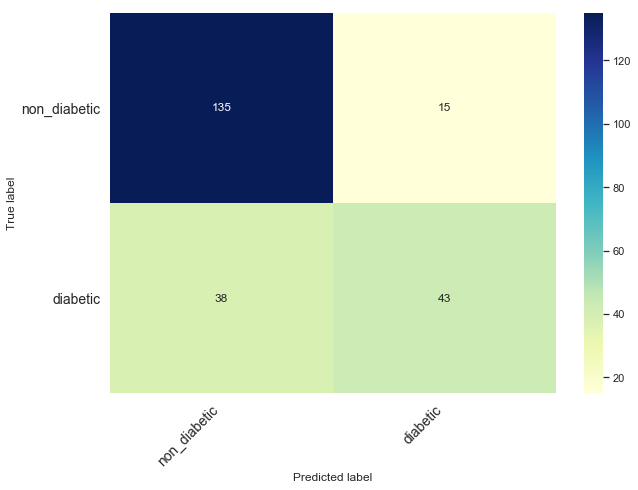

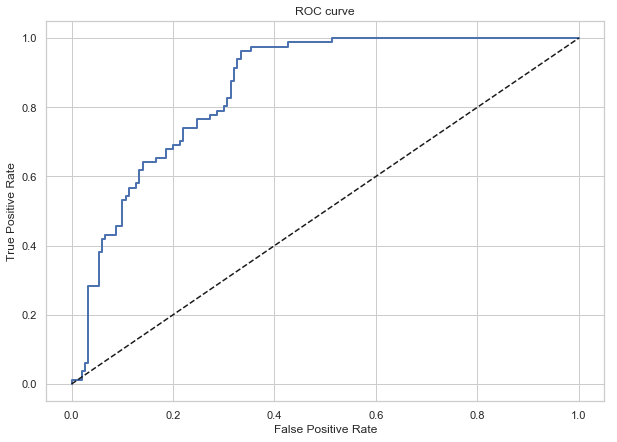

Area under the curve: 0.8557201646090535
f1 score on test set: 0.6187050359712232
Precision on test set: 0.7413793103448276
Recall on test set: 0.5308641975308642




In [156]:
plot_roc_cm('SVM')

#### Gradient boosting

Gradient_boosting


median-z-score
------------------------------------------------------------------------------------------


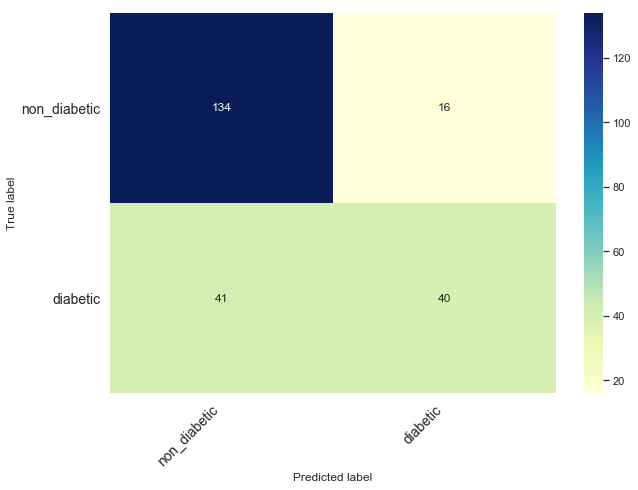

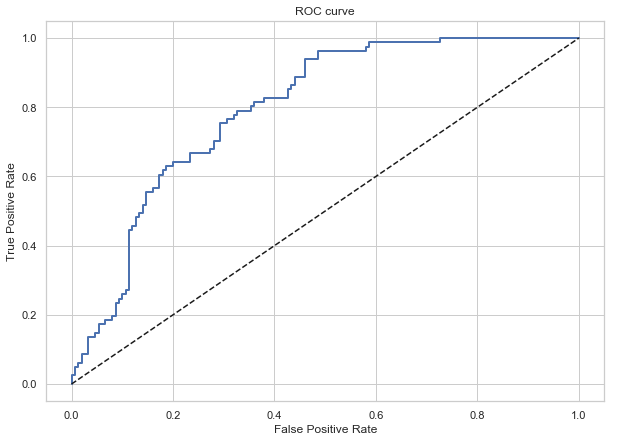

Area under the curve: 0.7961316872427983
f1 score on test set: 0.583941605839416
Precision on test set: 0.7142857142857143
Recall on test set: 0.49382716049382713


median-min-max
------------------------------------------------------------------------------------------


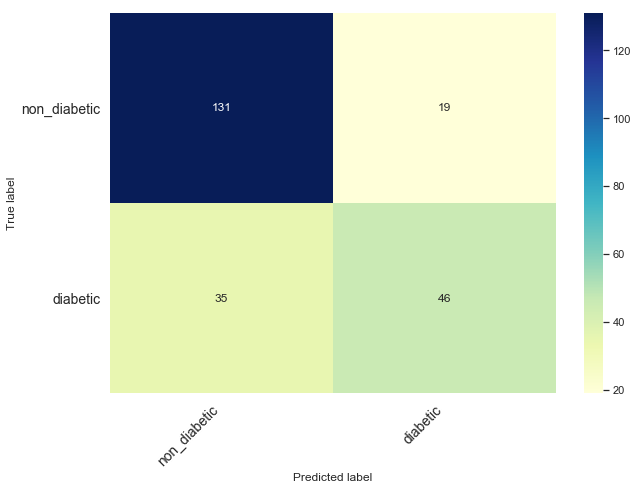

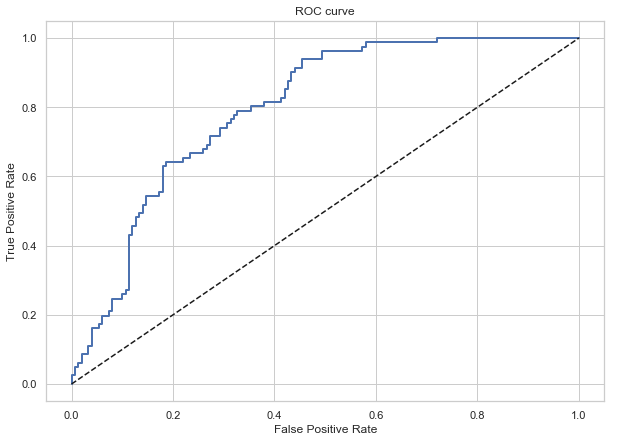

Area under the curve: 0.7976131687242798
f1 score on test set: 0.6301369863013698
Precision on test set: 0.7076923076923077
Recall on test set: 0.5679012345679012




In [157]:
plot_roc_cm('Gradient_boosting')

In [158]:
all_f1_test_df = pd.DataFrame(test_f1_auc, index=['f1_score', 'Recall', 'Precision', 'Accuracy', 'AUC'])
all_f1_test_df = all_f1_test_df.T
all_f1_test_df

,f1_score,Recall,Precision,Accuracy,AUC
Naive_Bayes_mean-z-score,0.6364,0.604938,0.671233,0.757576,0.832099
Naive_Bayes_mean-min-max,0.6364,0.604938,0.671233,0.757576,0.832099
KNN_mean-min-max,0.6014,0.530864,0.693548,0.753247,0.782757
KNN_median-min-max,0.5571,0.481481,0.661017,0.731602,0.803457
Logistic_regression_mean-z-score,0.5957,0.518519,0.700000,0.753247,0.844527
Logistic_regression_median-z-score,0.5957,0.518519,0.700000,0.753247,0.844198
Decision_tree_mean-min-max-PCA,0.6900,0.851852,0.579832,0.731602,0.602222
Decision_tree_median-min-max-PCA,0.7090,0.827160,0.620370,0.761905,0.641111
Random_forest_median-z-score,0.5839,0.493827,0.714286,0.753247,0.799012
Random_forest_median-min-max,0.5926,0.493827,0.740741,0.761905,0.808148


As we mentioned before, in medical diagnostics, recall might be more important than precision since the cost of falsely diagnose a diabetic patient to be non-diabetic is higher, but we do not want to sacrifice the precision too much either, otherwise we could have predicted all patients with diabetic to get a recall score of 1. Our next step is to rank the f1_score and recall, pick the top algorithm/data pair to and use the boostrapping method we used in previous accuracy model to see the consistency of the score

#### f1_score rank on test set

In [159]:
all_f1_test_df.sort_values(by=['f1_score'], ascending=False)

,f1_score,Recall,Precision,Accuracy,AUC
Decision_tree_median-min-max-PCA,0.7090,0.827160,0.620370,0.761905,0.641111
Decision_tree_mean-min-max-PCA,0.6900,0.851852,0.579832,0.731602,0.602222
Naive_Bayes_mean-z-score,0.6364,0.604938,0.671233,0.757576,0.832099
Naive_Bayes_mean-min-max,0.6364,0.604938,0.671233,0.757576,0.832099
Gradient_boosting_median-min-max,0.6301,0.567901,0.707692,0.766234,0.797613
SVM_median-min-max,0.6187,0.530864,0.741379,0.770563,0.855720
KNN_mean-min-max,0.6014,0.530864,0.693548,0.753247,0.782757
LSVM_median-min-max,0.6000,0.518519,0.711864,0.757576,0.848395
LSVM_median-z-score,0.5970,0.493827,0.754717,0.766234,0.839506
Logistic_regression_mean-z-score,0.5957,0.518519,0.700000,0.753247,0.844527


#### recall rank on test set

In [160]:
all_f1_test_df.sort_values(by=['Recall'], ascending=False)

,f1_score,Recall,Precision,Accuracy,AUC
Decision_tree_mean-min-max-PCA,0.6900,0.851852,0.579832,0.731602,0.602222
Decision_tree_median-min-max-PCA,0.7090,0.827160,0.620370,0.761905,0.641111
Naive_Bayes_mean-z-score,0.6364,0.604938,0.671233,0.757576,0.832099
Naive_Bayes_mean-min-max,0.6364,0.604938,0.671233,0.757576,0.832099
Gradient_boosting_median-min-max,0.6301,0.567901,0.707692,0.766234,0.797613
KNN_mean-min-max,0.6014,0.530864,0.693548,0.753247,0.782757
SVM_median-min-max,0.6187,0.530864,0.741379,0.770563,0.855720
Logistic_regression_mean-z-score,0.5957,0.518519,0.700000,0.753247,0.844527
Logistic_regression_median-z-score,0.5957,0.518519,0.700000,0.753247,0.844198
LSVM_median-min-max,0.6000,0.518519,0.711864,0.757576,0.848395


We can see from the above two tables, the f1 score and recall kind of agree with each other, this is actually what we are looking for, the top 5 of f1 score has only 1 different from the top 5 of recall, in fact, the top 6 of each actually matches each other. It will be interesting to see the correlation matrix between each score. One thing to note that the top 2 algorithm/data pair has pretty low AUC compared to others. Next we will use the boostrapping to find out the consistency of each model using both f1 score and recall

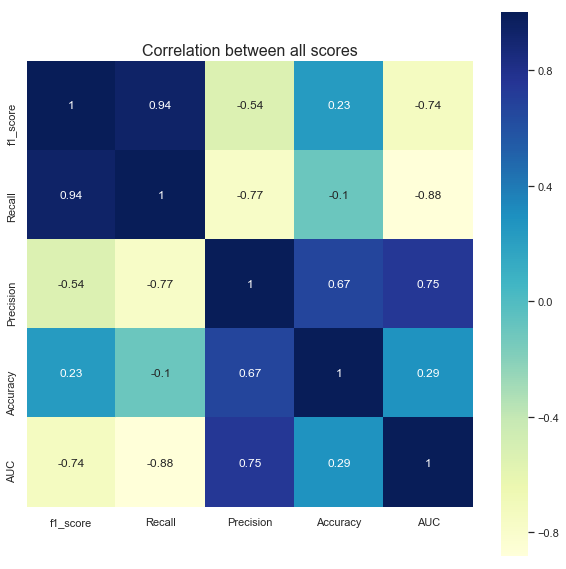

In [161]:
# plot correlation heatmap between all the scores
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.heatmap(all_f1_test_df.corr(), annot=True, cmap="YlGnBu",
            square=True)
ax.set_title('Correlation between all scores', size=16)
plt.show()

In [162]:
# define a helper function to generate sample index
def sample_index(size=100, iteration=2000):
    index_dict = {}
    for i in range(iteration):
        index = diabetes_y_test.sample(size, replace=True).index
        index_dict[i] = index
    return index_dict

In [163]:
# define helper function to plot the distribution of test score from random sampling
def bootstrapping(algo, data, index, kde=True):
    model = algorithm[algo](**all_params_f1_df.loc[data, algo])
    model.fit(data_all_train[data], diabetes_y_train)
    temp_data = pd.concat([data_all_test[data], diabetes_y_test], axis=1) # concatenate the outcome to sample together
    score_f1_list = []
    score_recall_list = []
    
    for i in range(len(index)):
        sample = temp_data.iloc[index[i]]
        score_f1 = f1_score(sample[0], model.predict(sample.drop([0], axis=1)))
        score_recall = recall_score(sample[0], model.predict(sample.drop([0], axis=1)))
        score_f1_list.append(score_f1)
        score_recall_list.append(score_recall)
    
    
    fig, ax = plt.subplots(1,2,figsize=(15,10))
    sns.distplot(score_f1_list, kde=kde, ax=ax[0])
    ax[0].set_title('f1 score distribution from test set', size=14)
    ax[0].set_xlabel('Score')
    
    sns.distplot(score_recall_list, kde=kde, ax=ax[1])
    ax[1].set_title('Recall score distribution from test set', size=14)
    ax[1].set_xlabel('Score')
    if not kde:
        ax[0].set_ylabel('Count')
        ax[1].set_ylabel('Count')
    plt.show()
    f1_score_mean = np.mean(score_f1_list)
    f1_score_std = np.std(score_f1_list)
    recall_score_mean = np.mean(score_recall_list)
    recall_score_std = np.std(score_recall_list)
    print('Average f1 test score from random sampling: {}'.format(f1_score_mean))
    print('CV% of f1 test score from random sampling: {}'.format(f1_score_std/f1_score_mean*100))
    print('Average recall test score from random sampling: {}'.format(recall_score_mean))
    print('CV% of recall test score from random sampling: {}'.format(recall_score_std/recall_score_mean*100))
   

#### Decision_tree_mean-min-max-PCA	

In [164]:
index = sample_index(size=100, iteration=2000)

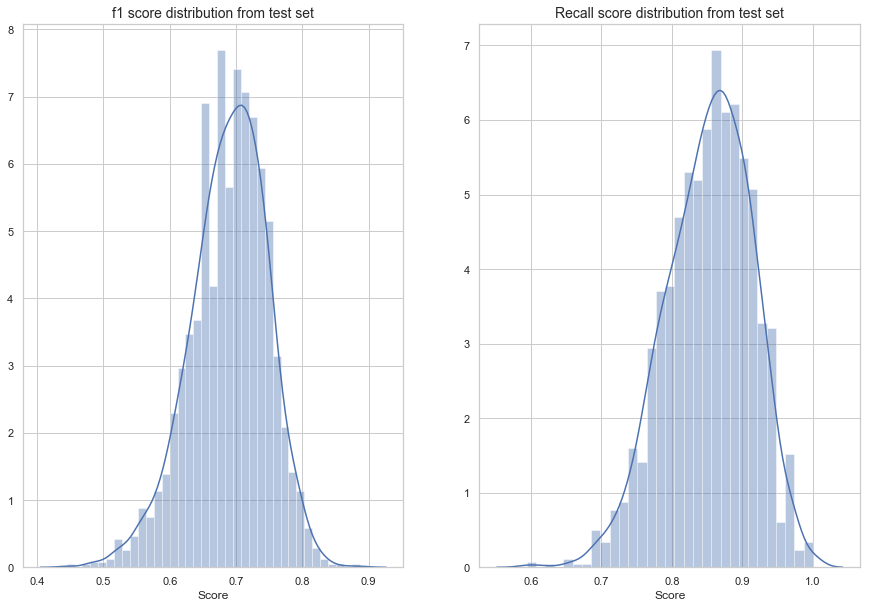

Average f1 test score from random sampling: 0.6890541491308829
CV% of f1 test score from random sampling: 8.40519453915398
Average recall test score from random sampling: 0.8524966536077159
CV% of recall test score from random sampling: 7.117302208250849


In [165]:
bootstrapping('Decision_tree', 'mean-min-max-PCA', index)

#### Decision_tree_median-min-max-PCA

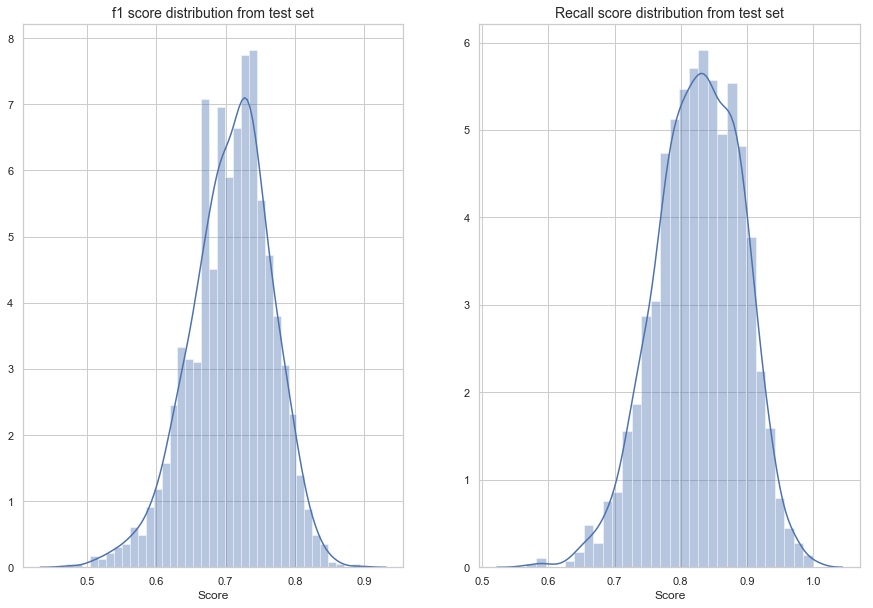

Average f1 test score from random sampling: 0.7077567092377086
CV% of f1 test score from random sampling: 8.236306829648527
Average recall test score from random sampling: 0.8273837219151919
CV% of recall test score from random sampling: 7.791237768758316


In [166]:
bootstrapping('Decision_tree', 'median-min-max-PCA', index)

#### LSVM_mean-min-max

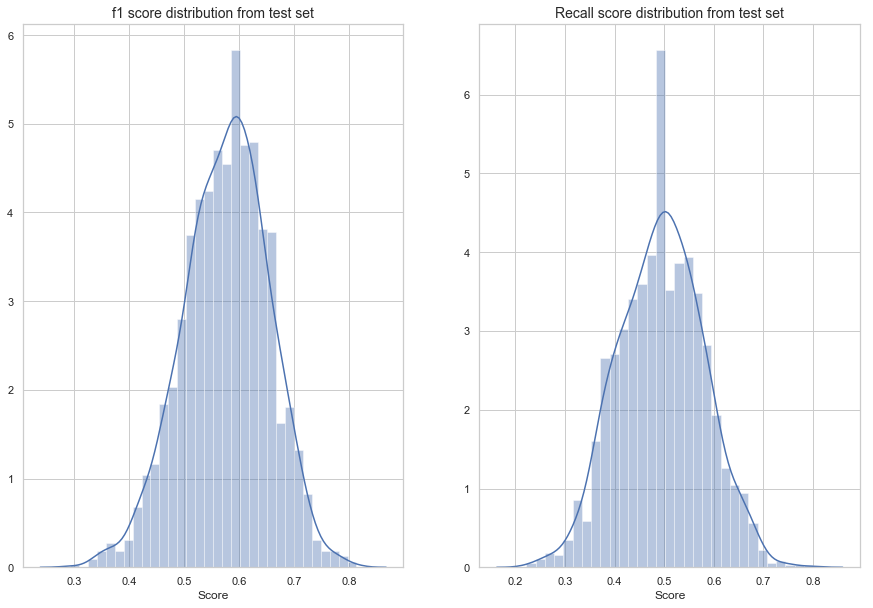

Average f1 test score from random sampling: 0.5763056523769167
CV% of f1 test score from random sampling: 13.458282034772463
Average recall test score from random sampling: 0.4938473468622609
CV% of recall test score from random sampling: 17.362898372973554


In [167]:
bootstrapping('LSVM', 'mean-min-max', index)

#### Naive_Bayes_mean-z-score	

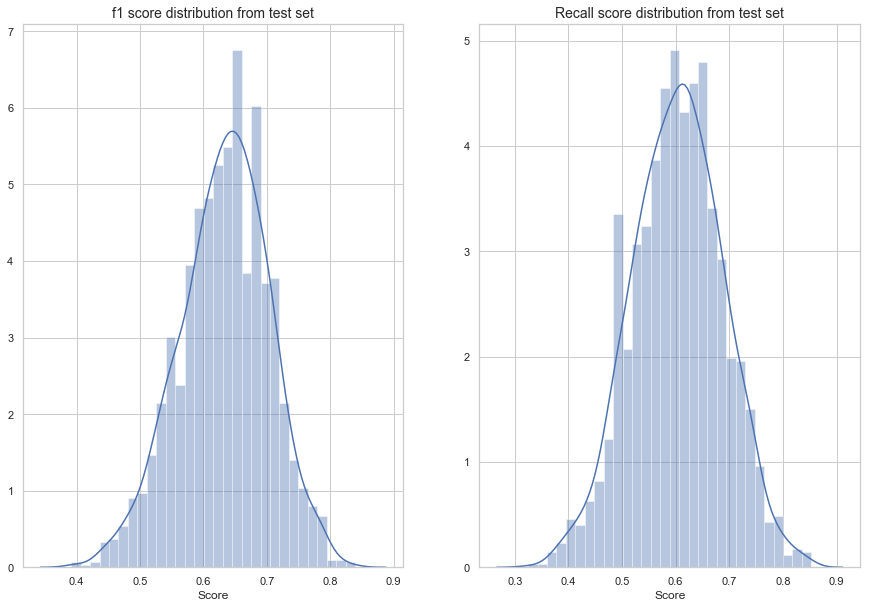

Average f1 test score from random sampling: 0.6330367276957456
CV% of f1 test score from random sampling: 11.061472133580729
Average recall test score from random sampling: 0.603812494573142
CV% of recall test score from random sampling: 13.951046195623661


In [168]:
bootstrapping('Naive_Bayes', 'mean-z-score', index)

#### Naive_Bayes_mean-min-max

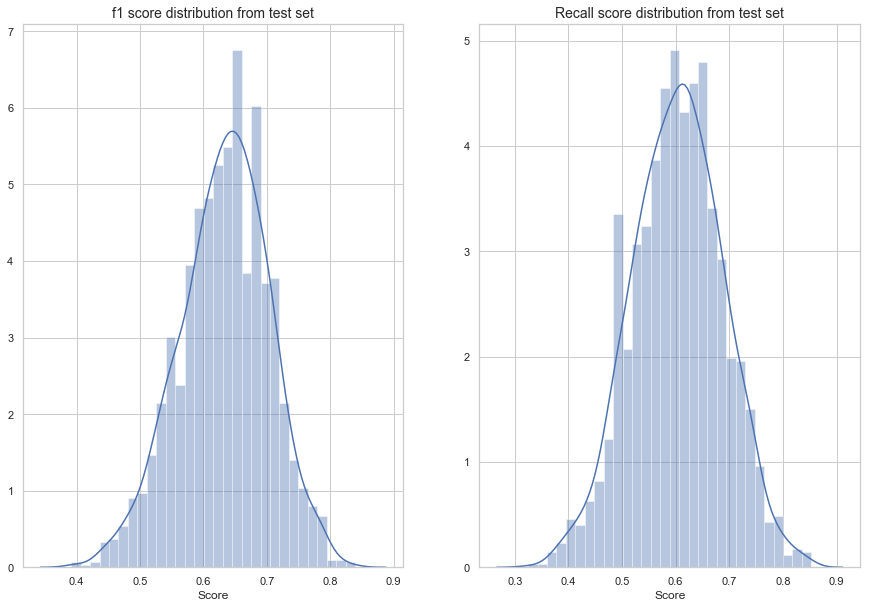

Average f1 test score from random sampling: 0.6330367276957456
CV% of f1 test score from random sampling: 11.061472133580729
Average recall test score from random sampling: 0.603812494573142
CV% of recall test score from random sampling: 13.951046195623661


In [169]:
bootstrapping('Naive_Bayes', 'mean-min-max', index)

#### Random_forest_median-z-score

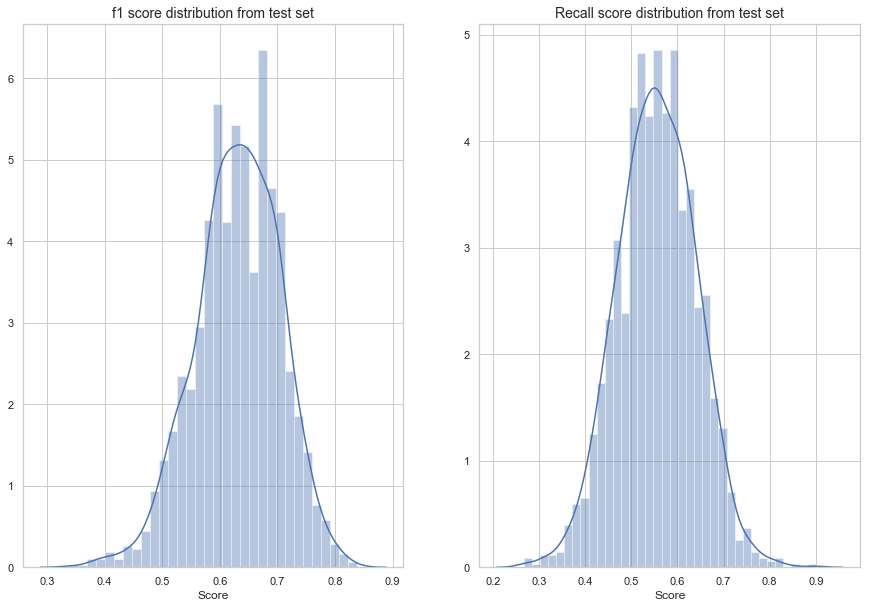

Average f1 test score from random sampling: 0.6310299476564776
CV% of f1 test score from random sampling: 11.596523174439417
Average recall test score from random sampling: 0.5552531000744377
CV% of recall test score from random sampling: 15.230289675626569


In [170]:
bootstrapping('Random_forest', 'median-z-score', index)

From the graphs showing above, we can clearly see a winner `Decision_tree_median-min-max-PCA`, which has the highest f1 score and the second highest recall score among all, moreover, by looking at the CV%, the algorithm/pair consistency is also higher than the other candidates

### Conclusions
In this notebook, we use f1 score/recall/precision as error matrix to find out the best model, this might be more ideal than the accuracy score as the reason mentioned in the beginning. By far, we have done many analysis of the model selection, we used the training set and the cross validation method to find out the best hyperparameters and the ideal combination between algorithms and processed data, then we use those hyperparameters on the test set to see the out of sample model performance. We then pick the top algorithms/data pairs and use the bootstrapping method to test the consistency of the model performance and pick the best one. We have found:
1. Tree models like decision tree and random forest have higher f1 score in general compare to others
2. Data that has variables transform to PCA components have lower f1 score in general compare to the feature engineered data
3. F1 score has high positive correlation with recall, but negative correlation with AUC and precision
4. Decision tree with PCA data have a good combination to have higher f1 score and recall, acceptable precision and consistency of the out-of-sample score, this is the ideal model we are looking for in medical diagnostics like diabetes detection
5. The time to fit the model has to be taken into account as well, sometimes it requires much more time to fit the model but only improve the performance by a really small margin, in the notebook we have shown that the decision tree takes little time to train, which suits our needs, if it was the more complicated model that has better performance, we have to consider the resource and time cost as well